In [10]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error


#Country to predict shipout and filepath to save trained models
country = "Japan"
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

pd.set_option('display.max_columns', None)
Ton_data = pd.read_csv('./Ton.csv')

In [11]:
T = Ton_data[country].values
T = T.astype('float32')
T = np.reshape(T, (-1, 1))

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
T = scaler.fit_transform(T)

# 70-30 split
train_size = int(len(T) * 0.70)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

# Method for create features from the month series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

# Roughly last 20 months
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

print(X_train.shape,Y_train.shape)
# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


# Checking to make sure that none of our training set is leaking into the testing set
T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

# Make sure that the number of rows in the dataset = train rows + test rows
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T_shape, train_shape, test_shape))

(225, 20) (225,)
False


In [12]:
# Model imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

# Setting seed for reproducibility 
tf.random.set_seed(11)
np.random.seed(11)

In [13]:
# Building model
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', #return_sequences = True, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = False,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 20, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

model.summary()

In [15]:
#prediction using model
from keras.models import load_model

best_model = load_model('saved_models/model_epoch_80.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

# Inverse transforming the actual values, to return them to their original values
print(Y_test.shape)
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

Y_hat_train = np.reshape(Y_hat_train, newshape = 225 )
Y_hat_test = np.reshape(Y_hat_test, newshape = 85)

Y_train = np.reshape(Y_train, newshape = 225 )
Y_test = np.reshape(Y_test, newshape = 85)

(85,)


In [25]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
547.5429432581891 

Test RMSE is: 
502.3367661375582


In [23]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
#seeing the results
result_df.head()

,Actual_Y,Predicted_Y
0,4037.000047,4407.916504
1,4119.999968,4427.489746
2,4052.999903,4480.298340
3,4891.999932,4450.350098
4,4171.000177,4557.474609


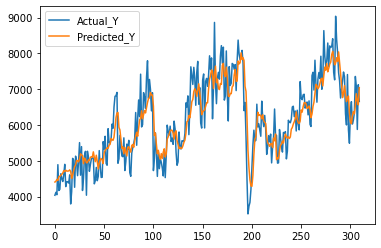

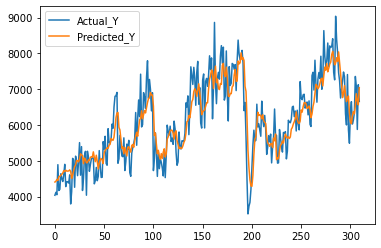

In [24]:
result_df.plot()
fig = result_df.plot().get_figure()

fig.savefig('Shipment.png')